## **IMPORT LIBRARIES**

In [ ]:
import glob
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import os
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization 
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU, ReLU, PReLU 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
from scipy import linalg
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

%matplotlib inline 

## **PART 1: LOOK AT THE BIG PICTURE (DONE)**

## **PART 2: GET THE DATA, LOAD DATA**
### **2.1. For cloud data (Google drive)** ###


In [ ]:
# Sync google drive storage to this notebook.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the folder.
!unzip /content/drive/MyDrive/pre_img_7000_64x64.zip -d /content/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/pre_img_clean2/face_2952.jpg  
  inflating: /content/pre_img_clean2/face_2953.jpg  
  inflating: /content/pre_img_clean2/face_2954.jpg  
  inflating: /content/pre_img_clean2/face_2955.jpg  
  inflating: /content/pre_img_clean2/face_2956.jpg  
  inflating: /content/pre_img_clean2/face_2957.jpg  
  inflating: /content/pre_img_clean2/face_2958.jpg  
  inflating: /content/pre_img_clean2/face_2959.jpg  
  inflating: /content/pre_img_clean2/face_296.jpg  
  inflating: /content/pre_img_clean2/face_2960.jpg  
  inflating: /content/pre_img_clean2/face_2961.jpg  
  inflating: /content/pre_img_clean2/face_2963.jpg  
  inflating: /content/pre_img_clean2/face_2964.jpg  
  inflating: /content/pre_img_clean2/face_2965.jpg  
  inflating: /content/pre_img_clean2/face_2966.jpg  
  inflating: /content/pre_img_clean2/face_2967.jpg  
  inflating: /content/pre_img_clean2/face_2968.jpg  
  inflating: /content/pre_img_clean2/face_2

### **2.2. For local data** ###

Define a function for loading dataset that will be used later in training section

In [ ]:
def read_images(data_dir):
  """
  This function reads all of the images in the specified directory and returns a Numpy array of the images.
  Arguments:
    data_dir: The directory containing the images.
  Returns:
    A NumPy array of the images, normalized to the range [0, 1].
  """
  # Create a list to store the images.
  images = []
  # Iterate over all of the files in the directory.
  for file_name in glob.glob(data_dir + '/*.jpg'):
    # Load the image from the file.
    img = image.load_img(file_name)
    # Convert the image to a NumPy array.
    img = image.img_to_array(img)
    # Append the image to the list.
    images.append(img)
  # Return a Numpy array of the images.
  return np.asarray(images) / 255.0

## **PART 3: DISCOVER THE DATA TO GAIN INSIGHTS**
Quick view of the data
* General infomation of the data

In [ ]:
def count_images(folder_path):
    image_extensions = ['.jpg']  # Add more extensions if needed
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in image_extensions:
            count += 1
    return count

# Usage
folder_path = '/content/pre_img_clean2'
image_count = count_images(folder_path)
print(f'Total number of images in the folder: {image_count}')

Total number of images in the folder: 7021


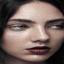

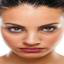

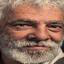

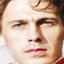

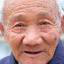

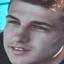

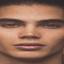

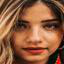

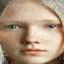

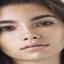

In [ ]:
def display_images(folder_path, num_images):
    image_files = [file_name for file_name in os.listdir(folder_path) if file_name.lower().endswith('.jpg')]

    if len(image_files) > 0:
        num_images = min(num_images, len(image_files))  # Limit the number of images to the available count
        for i in range(num_images):
            image_file = image_files[i]
            image_path = os.path.join(folder_path, image_file)
            image = Image.open(image_path)
            image.show()
    else:
        print('No images found in the folder.')

# Usage
folder_path = '/content/pre_img_clean2'
num_images = 10  # Display the first 10 images

display_images(folder_path, num_images)


## **PART 4. PREPARE THE DATA** (DONE)
All images are pre-scaled to 64x64 pixel and named face_n.jpg (n is the image number)

## **PART 5: TRAIN AND EVALUATE MODELS**
### ***5.1. The generator model***

In [ ]:
def build_generator(latent_dim):
  """
  Builds the generator model.
  Args:
    latent_dim: The dimensionality of the latent space.
  Returns:
    A Keras model that generates images from the latent space.
  """
  # Initialize the model.
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  model = Sequential(name='generator')

  # Add a dense layer to map the latent space to a 4x4x1024 tensor.
  model.add(Dense(4*4*1024, kernel_initializer=init, input_dim=latent_dim))

  # Add a batch normalization layer.
  model.add(BatchNormalization())

  # Add a ReLU activation layer.
  model.add(ReLU())

  # Reshape the tensor to a 4x4x1024 image.
  model.add(Reshape((4, 4, 1024)))

  # Add a series of convolutional transpose layers to upsample the image.
  model.add(Conv2DTranspose(512, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(ReLU())

  # Add a final convolutional layer to output a 3x3x3 image.
  model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', kernel_initializer=init))

  # Add a tanh activation layer to map the values to the range [-1, 1].
  model.add(Activation('tanh'))

  # Summarize the model.
  model.summary()

  # Return the model.
  return model


### ***5.2. The discriminator model***

In [ ]:
def build_discriminator(image_shape=(64, 64, 3)):
  """
  Builds the discriminator model.
  Args:
    image_shape: The shape of the input images.
  Returns:
    The discriminator model.
  """

  # Initialize the model.
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  model = Sequential(name='discriminator')

  # Add a convolutional layer with 128 filters, kernel size 3, strides 2, and padding 'same'.
  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', input_shape=image_shape, kernel_initializer=init))

  # Add a LeakyReLU activation layer with alpha=0.2.
  model.add(LeakyReLU(alpha=0.2))

  # Add a convolutional layer with 256 filters, kernel size 3, strides 2, and padding 'same'.
  model.add(Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=init))

  # Add a BatchNormalization layer.
  model.add(BatchNormalization())

  # Add a LeakyReLU activation layer with alpha=0.2.
  model.add(LeakyReLU(alpha=0.2))

  # Add a convolutional layer with 512 filters, kernel size 5, strides 2, and padding 'same'.
  model.add(Conv2D(512, kernel_size=5, strides=2, padding='same', kernel_initializer=init))

  # Add a BatchNormalization layer.
  model.add(BatchNormalization())

  # Add a LeakyReLU activation layer with alpha=0.2.
  model.add(LeakyReLU(alpha=0.2))

  # Add a convolutional layer with 1024 filters, kernel size 5, strides 2, and padding 'same'.
  model.add(Conv2D(1024, kernel_size=5, strides=2, padding='same', kernel_initializer=init))

  # Add a BatchNormalization layer.
  model.add(BatchNormalization())

  # Add a LeakyReLU activation layer with alpha=0.2.
  model.add(LeakyReLU(alpha=0.2))

  # Flatten the output of the convolutional layers.
  model.add(Flatten())

  # Add a dense layer with 1 output.
  model.add(Dense(1, kernel_initializer=init))

  # Add a sigmoid activation layer to output a probability between 0 and 1.
  model.add(Activation('sigmoid'))

  # Print a summary of the model.
  model.summary()

  # Return the model.
  return model


### ***5.3. Calculate model loss***

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

### ***5.4. Create GAN network***

- `DCGANs` (Deep Convolutional Generative Adversarial Network) are a type of GAN that use convolutional neural networks (CNNs) to generate images.
- The `DCGAN` class in the code inherits from the `Model` class in `Keras`. This means that it can be compiled and trained like any other Keras model.
1. The **`__init__`** method of the `DCGAN` class takes three arguments:
- `discriminator` (defined): A CNN that is used to distinguish between real and fake images.
- `generator` (defined): A CNN that is used to generate fake images.
- `latent_dim` (const): The dimensionality of the latent space.
2.  The **`compile`** method of the `DCGAN` class takes two arguments:
- `d_optimizer`: An optimizer that is used to train the discriminator.
- `g_optimizer`: An optimizer that is used to train the generator.
3. The **`generator_loss`** method of the `DCGAN` class takes one argument:
- `fake_output`: The output of the generator.
- The `generator_loss` method simply returns the cross-entropy loss between the fake output and a one-hot vector of ones. This loss encourages the generator to produce images that are indistinguishable from real images.
4. The **`discriminator_loss`** method of the `DCGAN` class takes two arguments:
- `real_output`: The output of the discriminator on real images.
- `fake_output`: The output of the discriminator on fake images.
- The `discriminator_loss` method first calculates the cross-entropy loss between the real output and a one-hot vector of ones. It then calculates the cross-entropy loss between the fake output and a one-hot vector of zeros. Finally, it adds these two losses together. This loss encourages the discriminator to be able to distinguish between real and fake images.
5. The **`train_step`** method of the DCGAN class takes one argument:
- `real_images`: A batch of real images.
- The `train_step` method first samples a batch of random points from the latent space. It then uses these points to generate a batch of fake images. The train_step method then trains the discriminator on the real images and the fake images. Finally, it trains the generator on the fake images.











In [ ]:
class DCGAN(Model):
  def __init__(self, discriminator, generator, latent_dim): 
    super(DCGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim= latent_dim
  def compile(self, d_optimizer, g_optimizer):
    super(DCGAN, self).compile() 
    self.d_optimizer = d_optimizer 
    self.g_optimizer = g_optimizer
    self.d_loss_metric = keras.metrics.Mean(name='d_loss')
    self.g_loss_metric = keras.metrics.Mean(name='g_loss')
  def generator_loss(self, fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  def discriminator_loss(self, real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) 
    total_loss = real_loss + fake_loss
    return total_loss

  @tf.function
  def train_step(self, real_images):
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    # Train the discriminator
    with tf.GradientTape() as discriminator_tape:
      generated_images = self.generator(random_latent_vectors) 
      real_output = self.discriminator(real_images)
      fake_output = self.discriminator(generated_images)
      d_loss = self.discriminator_loss(real_output, fake_output)
    discriminator_grads = discriminator_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(discriminator_grads,self.discriminator.trainable_weights))
                                          
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    # Train the generator
    with tf.GradientTape() as generator_tape:
      generated_images = self.generator(random_latent_vectors)
      fake_output = self.discriminator(generated_images) 
      g_loss = self.generator_loss(fake_output)
    generator_grads = generator_tape.gradient(g_loss, self.generator.trainable_weights) 
    self.g_optimizer.apply_gradients(zip(generator_grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss) 
    self.g_loss_metric.update_state(g_loss)
    return {
        'd_loss': self.d_loss_metric.result(), 
        'g_loss': self.g_loss_metric.result(),
    } 


### ***5.5. Monitoring the network***

Method of saving the model and watching the training process

In [ ]:
class GANMonitor(keras.callbacks.Callback): 
  def __init__(self, num_img=3, latent_dim=128): 
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.best_fid = float('inf')  # Initialize best_fid with a large value

  def on_epoch_end(self, epoch, logs=None):
    if epoch%5 == 0:
      random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) 
      generated_images = self.model.generator(random_latent_vectors)
      fig = plt.figure(figsize=(10, 4))

      # Calculate FID using generated images and real images from dataset
      fid = calculate_fid(X_train[:self.num_img], generated_images.numpy())
        
      print(f'FID at epoch {epoch}: {fid}')
        # Save the model if it achieves the best FID
      if fid < self.best_fid:
        self.best_fid = fid
        self.model.generator.save('/content/best_model.h5')

      for i in range(self.num_img):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i,:,:,:]* 0.5 +0.5)
        plt.axis('off')
      plt.show() 

### ***5.6. Validating***
calculating the Fréchet Inception Distance (FID) between two sets of images: real images and generated images. FID is a metric used to evaluate the similarity between two sets of images based on their feature representations extracted from a pre-trained Inception-v3 model.


Overall, this function allows you to quantify the similarity between the distributions of features extracted from real and generated images using the Fréchet Inception Distance metric.

In [ ]:
def calculate_fid(real_images, generated_images):
    # Load the Inception-v3 model pre-trained on ImageNet
    model = InceptionV3(include_top=False, pooling='avg')
  
    # Resize the images to match the minimum input size of InceptionV3
    real_images_resized = np.array([resize(img, (75, 75)) for img in real_images])
    generated_images_resized = np.array([resize(img, (75, 75)) for img in generated_images])
  
    # Preprocess the images
    real_images_resized = preprocess_input(real_images_resized)
    generated_images_resized = preprocess_input(generated_images_resized)
  
    # Extract the features from the Inception-v3 model
    real_features = model.predict(real_images_resized)
    generated_features = model.predict(generated_images_resized)
  
    # Compute the mean and covariance of the real and generated features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
  
    # Compute the squared Euclidean distance between the means
    diff = mu_real - mu_generated
    fid = np.dot(diff, diff) + np.trace(sigma_real + sigma_generated - 2 * linalg.sqrtm(np.dot(sigma_real, sigma_generated)))
  
    return fid

### ***5.7. Start training***
#### ***5.7.1. Getting the generator and discriminator models*** ####



In [ ]:
latent_dim = 128

generator = build_generator(latent_dim)
discriminator = build_discriminator()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      3277056   
 ranspose)                                                       
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
          

#### ***5.7.2. Getting the GAN model***####

In [ ]:
gan= DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim) 
gan.compile(
    d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5), 
    g_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
)

#### ***5.7.3. Reading the dataset***####

In [ ]:
X_train = read_images('/content/pre_img_clean2')
print(X_train.shape)

(7021, 64, 64, 3)


#### ***5.7.4. Fitting the model (most important step)***####

Epoch 1/120
1/1 [==============================] - 0s 27ms/step


FID at epoch 0: (36.35071291819365-6.668942466525213e-08j)


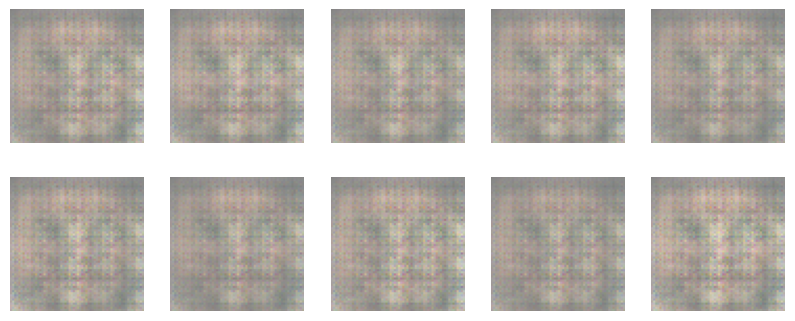

220/220 [==============================] - 85s 306ms/step - d_loss: 1.2903 - g_loss: 1.3123
Epoch 2/120
220/220 [==============================] - 52s 236ms/step - d_loss: 1.3019 - g_loss: 1.2444
Epoch 3/120
220/220 [==============================] - 51s 234ms/step - d_loss: 1.2348 - g_loss: 1.2895
Epoch 4/120
220/220 [==============================] - 52s 235ms/step - d_loss: 1.1980 - g_loss: 1.4852
Epoch 5/120
220/220 [==============================] - 52s 234ms/step - d_loss: 1.2136 - g_loss: 1.5380
Epoch 6/120
1/1 [==============================] - 0s 27ms/step


FID at epoch 5: (23.393393356307048-3.579810529548976e-07j)


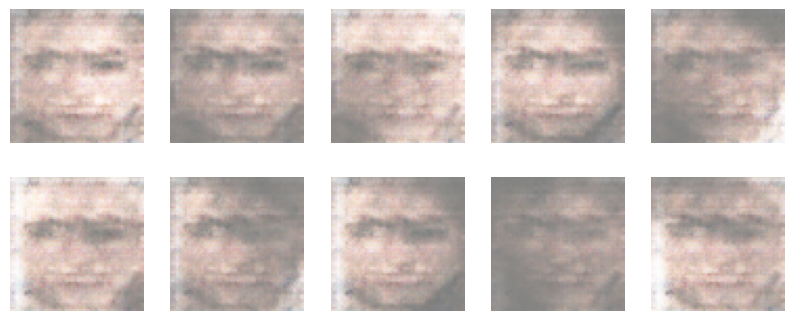

220/220 [==============================] - 64s 291ms/step - d_loss: 1.2196 - g_loss: 1.5924
Epoch 7/120
220/220 [==============================] - 52s 237ms/step - d_loss: 1.1734 - g_loss: 1.5577
Epoch 8/120
220/220 [==============================] - 51s 234ms/step - d_loss: 1.2376 - g_loss: 1.4977
Epoch 9/120
220/220 [==============================] - 52s 235ms/step - d_loss: 1.1307 - g_loss: 1.6960
Epoch 10/120
220/220 [==============================] - 51s 234ms/step - d_loss: 1.2072 - g_loss: 1.5225
Epoch 11/120
1/1 [==============================] - 0s 25ms/step
FID at epoch 10: (26.611600078511103-4.028609526344332e-07j)


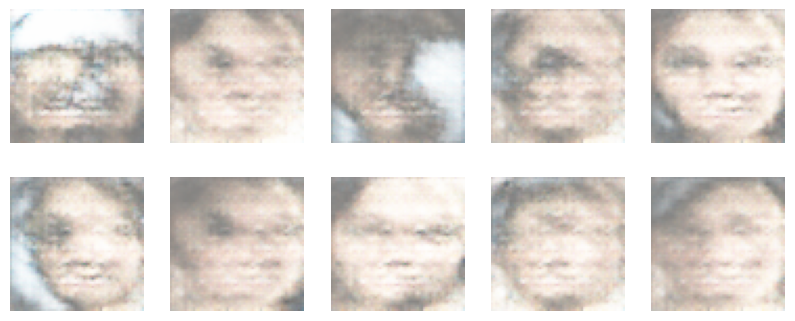

220/220 [==============================] - 62s 280ms/step - d_loss: 1.1379 - g_loss: 1.6002
Epoch 12/120
220/220 [==============================] - 52s 237ms/step - d_loss: 1.0825 - g_loss: 1.6757
Epoch 13/120
220/220 [==============================] - 51s 233ms/step - d_loss: 1.0874 - g_loss: 1.6934
Epoch 14/120
220/220 [==============================] - 52s 235ms/step - d_loss: 1.0960 - g_loss: 1.6869
Epoch 15/120
220/220 [==============================] - 51s 233ms/step - d_loss: 1.0558 - g_loss: 1.7621
Epoch 16/120
1/1 [==============================] - 0s 28ms/step
FID at epoch 15: (24.476105693631272-7.256143168680022e-07j)


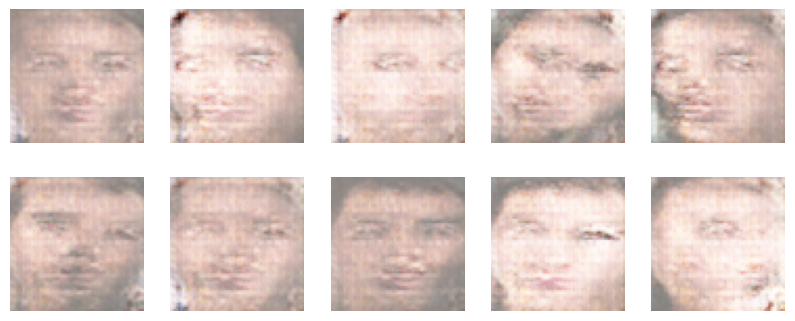

220/220 [==============================] - 63s 285ms/step - d_loss: 1.0652 - g_loss: 1.7617
Epoch 17/120
220/220 [==============================] - 52s 235ms/step - d_loss: 1.0566 - g_loss: 1.8161
Epoch 18/120
220/220 [==============================] - 51s 233ms/step - d_loss: 1.0235 - g_loss: 1.8671
Epoch 19/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.9757 - g_loss: 1.9483
Epoch 20/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.9255 - g_loss: 2.0704
Epoch 21/120
220/220 [==============================] - ETA: 0s - d_loss: 0.9656 - g_loss: 2.0612

1/1 [==============================] - 0s 24ms/step
FID at epoch 20: (26.293406395656206-3.542538392394185e-07j)


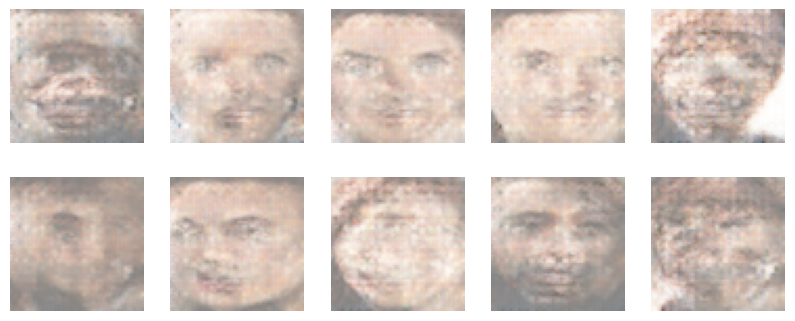

220/220 [==============================] - 62s 284ms/step - d_loss: 0.9656 - g_loss: 2.0612
Epoch 22/120
220/220 [==============================] - 52s 237ms/step - d_loss: 0.8982 - g_loss: 2.1313
Epoch 23/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.9029 - g_loss: 2.0998
Epoch 24/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.8742 - g_loss: 2.1910
Epoch 25/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.8765 - g_loss: 2.2307
Epoch 26/120
220/220 [==============================] - ETA: 0s - d_loss: 0.8872 - g_loss: 2.1318

1/1 [==============================] - 0s 24ms/step
FID at epoch 25: (23.970620469519815-4.3830889135812454e-07j)


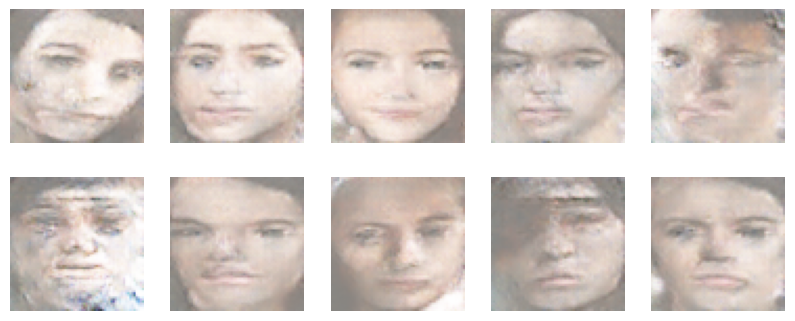

220/220 [==============================] - 61s 276ms/step - d_loss: 0.8872 - g_loss: 2.1318
Epoch 27/120
220/220 [==============================] - 52s 236ms/step - d_loss: 0.8128 - g_loss: 2.1967
Epoch 28/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.8304 - g_loss: 2.1706
Epoch 29/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.7991 - g_loss: 2.1972
Epoch 30/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.7981 - g_loss: 2.2468
Epoch 31/120
1/1 [==============================] - 0s 25ms/step


FID at epoch 30: (21.489158152532774-5.756881560504296e-07j)


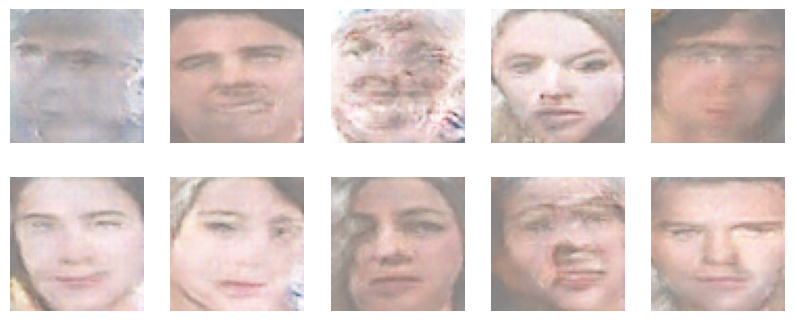

220/220 [==============================] - 62s 280ms/step - d_loss: 0.7718 - g_loss: 2.3172
Epoch 32/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.7419 - g_loss: 2.3695
Epoch 33/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.7357 - g_loss: 2.4025
Epoch 34/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.6968 - g_loss: 2.4549
Epoch 35/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.6725 - g_loss: 2.6053
Epoch 36/120
1/1 [==============================] - 0s 28ms/step


FID at epoch 35: (18.64150141675706-3.410603412685899e-07j)


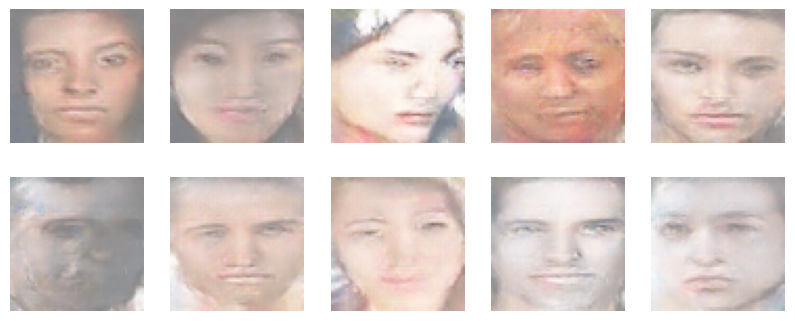

220/220 [==============================] - 61s 279ms/step - d_loss: 0.6455 - g_loss: 2.6430
Epoch 37/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.6194 - g_loss: 2.7325
Epoch 38/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.6196 - g_loss: 2.8422
Epoch 39/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.5499 - g_loss: 2.9302
Epoch 40/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.5423 - g_loss: 2.9769
Epoch 41/120
1/1 [==============================] - 0s 52ms/step


FID at epoch 40: (17.30742722978975-4.6971989816232185e-07j)


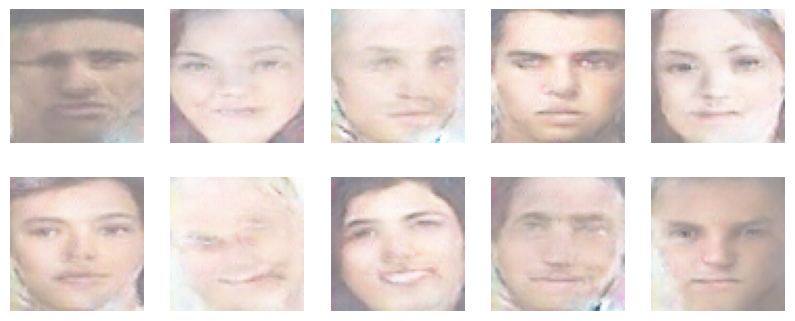

220/220 [==============================] - 62s 281ms/step - d_loss: 0.6134 - g_loss: 2.9724
Epoch 42/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.4841 - g_loss: 3.0637
Epoch 43/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.4861 - g_loss: 3.2225
Epoch 44/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.4360 - g_loss: 3.3747
Epoch 45/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.4279 - g_loss: 3.4797
Epoch 46/120
1/1 [==============================] - 0s 54ms/step
FID at epoch 45: (20.473074921149724-3.4220202355604104e-07j)


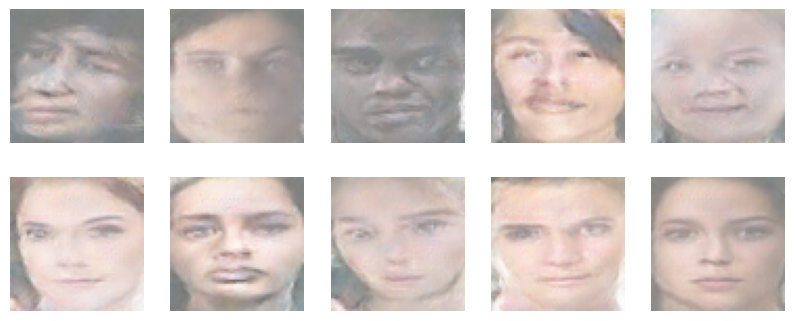

220/220 [==============================] - 62s 280ms/step - d_loss: 0.4131 - g_loss: 3.5439
Epoch 47/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.3936 - g_loss: 3.6858
Epoch 48/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.3924 - g_loss: 3.7007
Epoch 49/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.3651 - g_loss: 3.8521
Epoch 50/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.3287 - g_loss: 3.9784
Epoch 51/120
1/1 [==============================] - 0s 35ms/step
FID at epoch 50: (22.2315624384442-2.033238852791389e-07j)


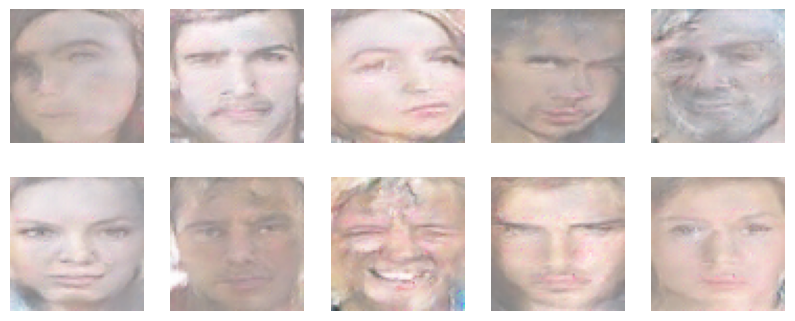

220/220 [==============================] - 62s 281ms/step - d_loss: 0.3722 - g_loss: 4.1006
Epoch 52/120
220/220 [==============================] - 52s 236ms/step - d_loss: 1.2789 - g_loss: 3.8642
Epoch 53/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.6181 - g_loss: 3.0264
Epoch 54/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.3200 - g_loss: 3.3181
Epoch 55/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.2640 - g_loss: 3.6461
Epoch 56/120
1/1 [==============================] - 0s 24ms/step
FID at epoch 55: (20.523028841507468-3.3084593431883034e-07j)


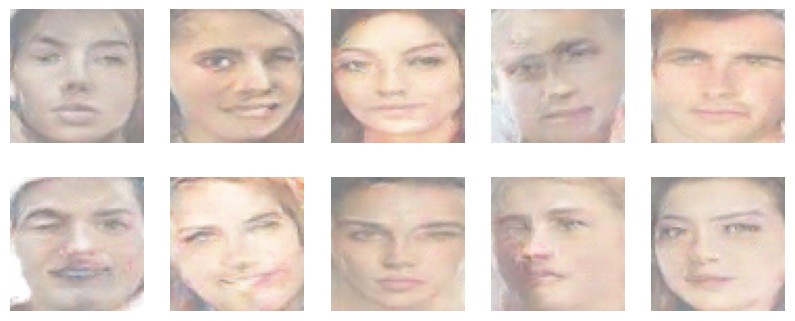

220/220 [==============================] - 60s 275ms/step - d_loss: 0.2487 - g_loss: 3.9026
Epoch 57/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.2494 - g_loss: 4.0857
Epoch 58/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.2443 - g_loss: 4.2948
Epoch 59/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.2722 - g_loss: 4.4299
Epoch 60/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.2334 - g_loss: 4.4611
Epoch 61/120
1/1 [==============================] - 0s 36ms/step
FID at epoch 60: (21.796325759093033-6.115467060612487e-07j)


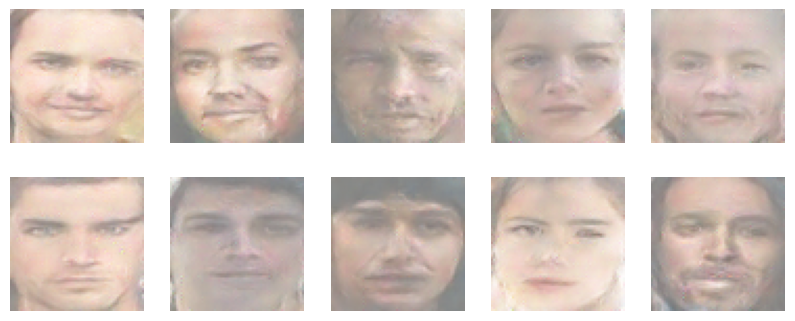

220/220 [==============================] - 61s 278ms/step - d_loss: 0.2889 - g_loss: 4.4466
Epoch 62/120
220/220 [==============================] - 52s 236ms/step - d_loss: 0.2184 - g_loss: 4.6654
Epoch 63/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.2602 - g_loss: 4.9326
Epoch 64/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.2564 - g_loss: 4.9872
Epoch 65/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1784 - g_loss: 4.8054
Epoch 66/120
1/1 [==============================] - 0s 38ms/step
FID at epoch 65: (22.55899072747885-2.82886694548131e-07j)


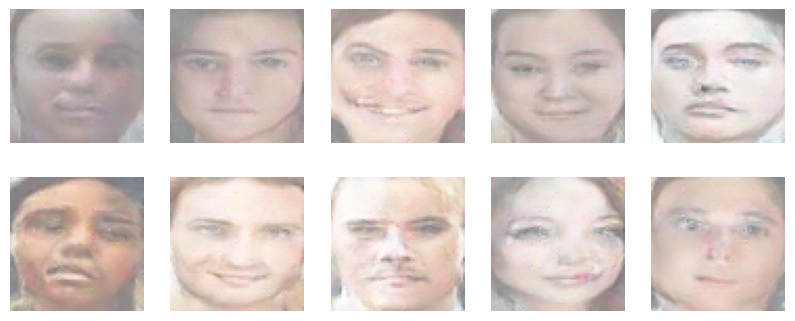

220/220 [==============================] - 62s 281ms/step - d_loss: 0.2415 - g_loss: 5.2931
Epoch 67/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.1908 - g_loss: 5.1632
Epoch 68/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1893 - g_loss: 5.3697
Epoch 69/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.1638 - g_loss: 5.3849
Epoch 70/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.2073 - g_loss: 5.5905
Epoch 71/120
1/1 [==============================] - 0s 37ms/step
FID at epoch 70: (22.27716646629156-2.182164790056735e-07j)


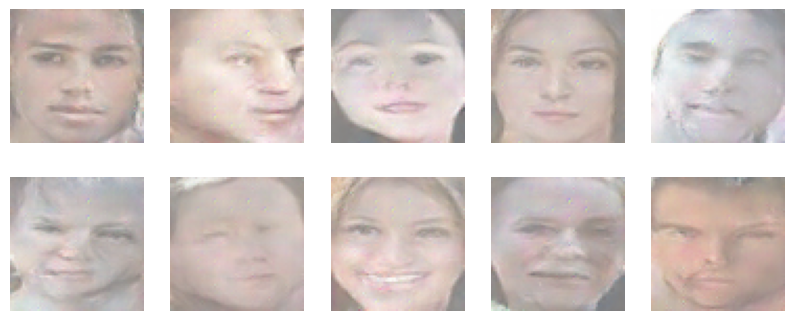

220/220 [==============================] - 61s 279ms/step - d_loss: 0.2237 - g_loss: 5.5797
Epoch 72/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.2267 - g_loss: 5.6296
Epoch 73/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.1438 - g_loss: 5.6008
Epoch 74/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.1252 - g_loss: 5.8203
Epoch 75/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.2205 - g_loss: 5.9351
Epoch 76/120
1/1 [==============================] - 0s 36ms/step
FID at epoch 75: (23.081237596780234-3.8129890974855866e-07j)


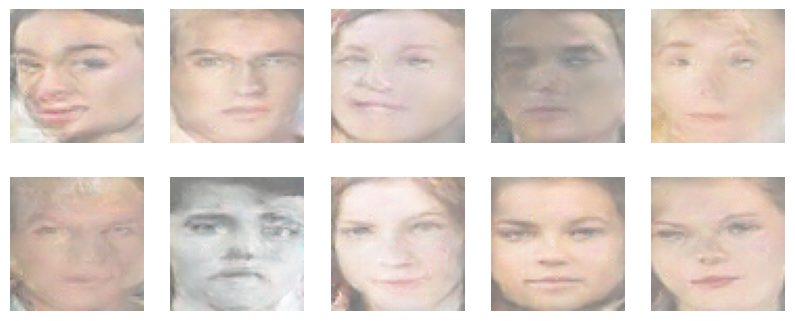

220/220 [==============================] - 61s 277ms/step - d_loss: 0.1503 - g_loss: 6.0116
Epoch 77/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.2862 - g_loss: 6.0826
Epoch 78/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1214 - g_loss: 5.7323
Epoch 79/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1466 - g_loss: 6.0896
Epoch 80/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.1256 - g_loss: 6.2108
Epoch 81/120
1/1 [==============================] - 0s 35ms/step
FID at epoch 80: (21.0970655937236-2.4007471570136897e-07j)


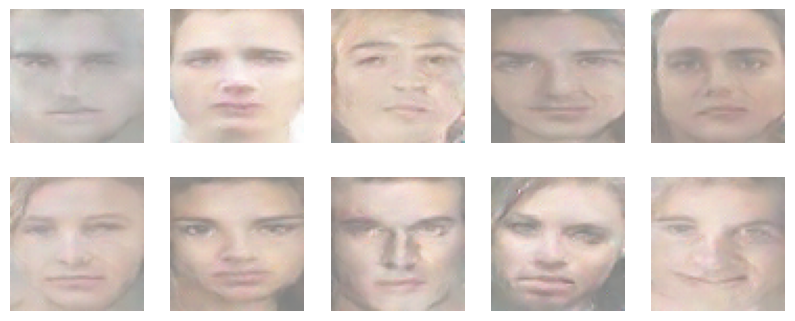

220/220 [==============================] - 62s 282ms/step - d_loss: 0.1044 - g_loss: 6.4231
Epoch 82/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.2481 - g_loss: 6.4323
Epoch 83/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1734 - g_loss: 6.3026
Epoch 84/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.0756 - g_loss: 6.1241
Epoch 85/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.1323 - g_loss: 6.7047
Epoch 86/120
1/1 [==============================] - 0s 47ms/step
FID at epoch 85: (20.234884866593923-2.234691262796803e-07j)


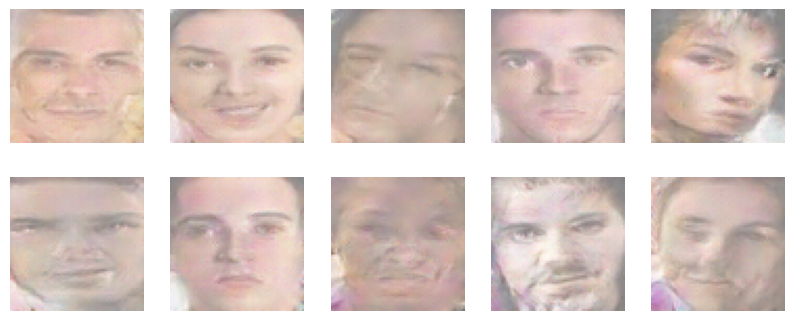

220/220 [==============================] - 61s 280ms/step - d_loss: 0.1850 - g_loss: 6.9140
Epoch 87/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.0968 - g_loss: 6.6870
Epoch 88/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1176 - g_loss: 6.7742
Epoch 89/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.2112 - g_loss: 7.3217
Epoch 90/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.0857 - g_loss: 6.6437
Epoch 91/120
1/1 [==============================] - 0s 37ms/step
FID at epoch 90: (22.67810160748157-4.0127652030064315e-07j)


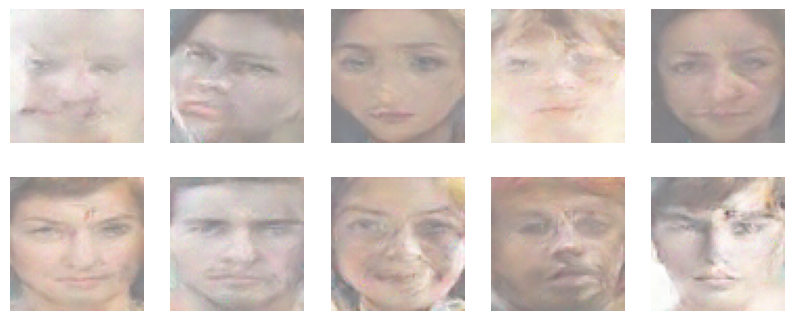

220/220 [==============================] - 62s 281ms/step - d_loss: 0.0831 - g_loss: 7.1674
Epoch 92/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.1787 - g_loss: 7.1931
Epoch 93/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.1475 - g_loss: 7.1748
Epoch 94/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.0932 - g_loss: 7.3032
Epoch 95/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.1114 - g_loss: 7.3285
Epoch 96/120
1/1 [==============================] - 0s 40ms/step
FID at epoch 95: (21.760497821960517-3.123757647785144e-07j)


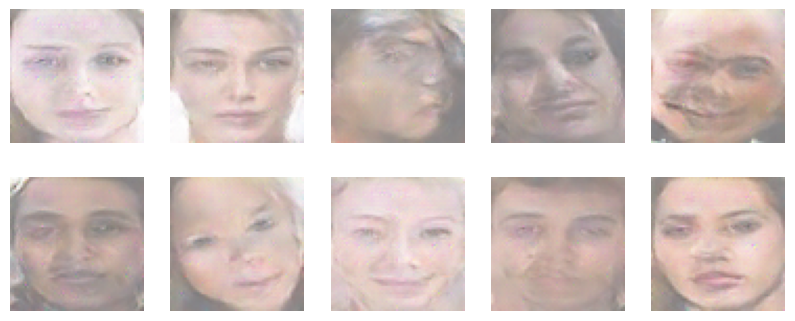

220/220 [==============================] - 61s 278ms/step - d_loss: 0.0789 - g_loss: 7.3261
Epoch 97/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.2059 - g_loss: 7.7470
Epoch 98/120
220/220 [==============================] - 51s 232ms/step - d_loss: 1.6841 - g_loss: 12.0824
Epoch 99/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.5253 - g_loss: 7.9604
Epoch 100/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.0881 - g_loss: 5.7910
Epoch 101/120
1/1 [==============================] - 0s 37ms/step
FID at epoch 100: (26.00241043727945-2.733802627921179e-07j)


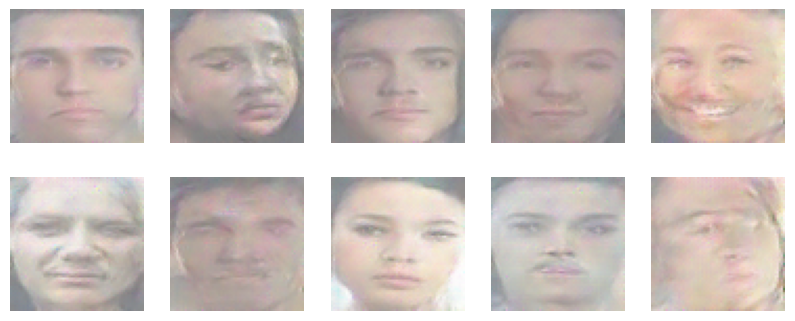

220/220 [==============================] - 62s 282ms/step - d_loss: 0.0718 - g_loss: 5.7176
Epoch 102/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.0740 - g_loss: 5.9744
Epoch 103/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.0555 - g_loss: 6.2394
Epoch 104/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.0331 - g_loss: 6.3050
Epoch 105/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.0395 - g_loss: 6.6108
Epoch 106/120
1/1 [==============================] - 0s 36ms/step
FID at epoch 105: (19.648130079254862-4.3234218460179415e-07j)


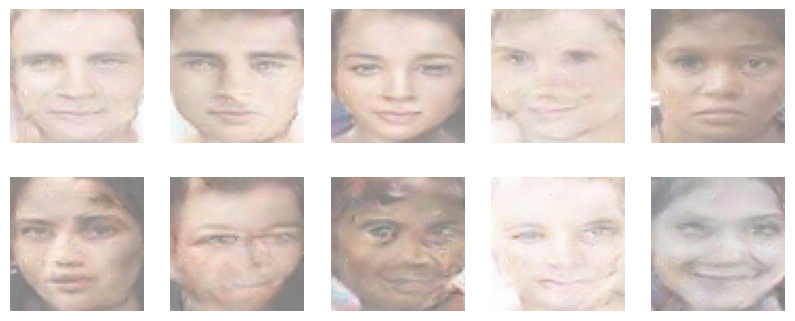

220/220 [==============================] - 61s 276ms/step - d_loss: 0.0756 - g_loss: 7.3139
Epoch 107/120
220/220 [==============================] - 52s 235ms/step - d_loss: 0.0524 - g_loss: 7.2913
Epoch 108/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.0437 - g_loss: 7.4757
Epoch 109/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.0468 - g_loss: 8.2385
Epoch 110/120
220/220 [==============================] - 51s 233ms/step - d_loss: 0.0650 - g_loss: 8.2009
Epoch 111/120
1/1 [==============================] - 0s 40ms/step
FID at epoch 110: (21.475070756260923-1.1578873971789307e-07j)


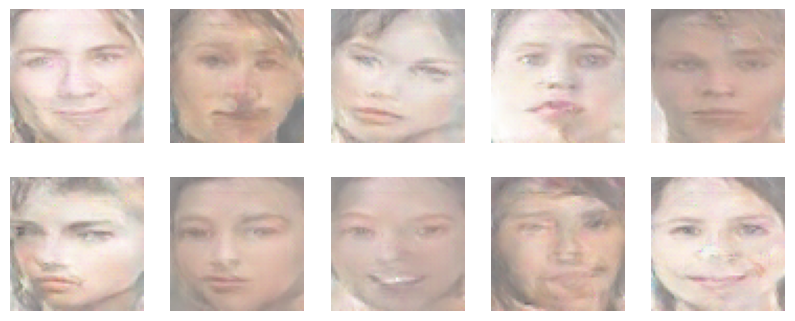

220/220 [==============================] - 62s 281ms/step - d_loss: 0.1049 - g_loss: 8.8825
Epoch 112/120
220/220 [==============================] - 52s 234ms/step - d_loss: 0.0625 - g_loss: 8.0749
Epoch 113/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.3911 - g_loss: 8.6034
Epoch 114/120
220/220 [==============================] - 51s 234ms/step - d_loss: 0.0657 - g_loss: 7.8187
Epoch 115/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.0472 - g_loss: 12.5892
Epoch 116/120
1/1 [==============================] - 0s 40ms/step
FID at epoch 115: (29.77060380799086-2.477092523922828e-07j)


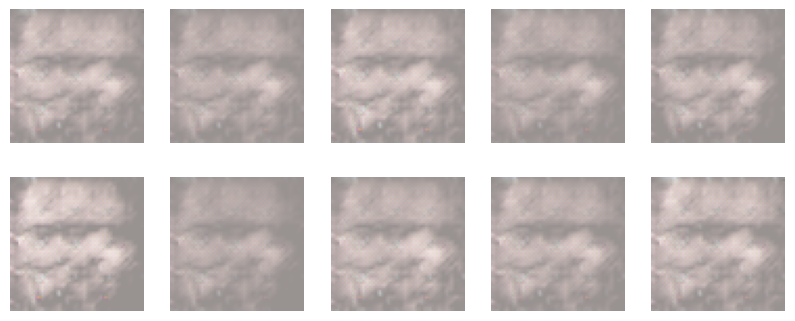

220/220 [==============================] - 61s 276ms/step - d_loss: 0.0292 - g_loss: 14.4029
Epoch 117/120
220/220 [==============================] - 51s 232ms/step - d_loss: 0.0614 - g_loss: 13.7410
Epoch 118/120
220/220 [==============================] - 50s 229ms/step - d_loss: 0.0091 - g_loss: 17.3217
Epoch 119/120
220/220 [==============================] - 51s 230ms/step - d_loss: 1.3689 - g_loss: 18.9159
Epoch 120/120
220/220 [==============================] - 51s 231ms/step - d_loss: 0.5945 - g_loss: 21.5424


In [ ]:
gan_monitor = GANMonitor(num_img=10, latent_dim=latent_dim)

history = gan.fit(X_train, epochs=120, callbacks=[gan_monitor])

### ***5.8. Evaluating the model***###

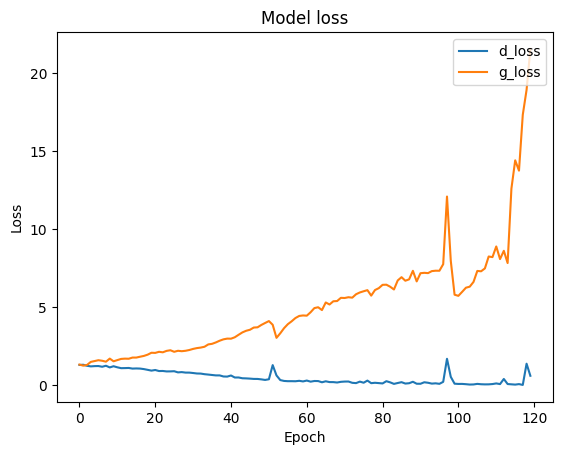

In [ ]:
# Plot the discriminator and generator loss values over epochs
plt.plot(history.history['d_loss'])  # Plot the discriminator loss values
plt.plot(history.history['g_loss'])  # Plot the generator loss values

plt.title('Model loss')  # Set the title of the plot
plt.ylabel('Loss')  # Set the label for the y-axis
plt.xlabel('Epoch')  # Set the label for the x-axis

plt.legend(['d_loss', 'g_loss'], loc='upper right')  # Add a legend indicating the plotted lines

plt.show()  # Display the plot


### ***5.9. Generate fake images***###

1/1 [==============================] - 0s 158ms/step


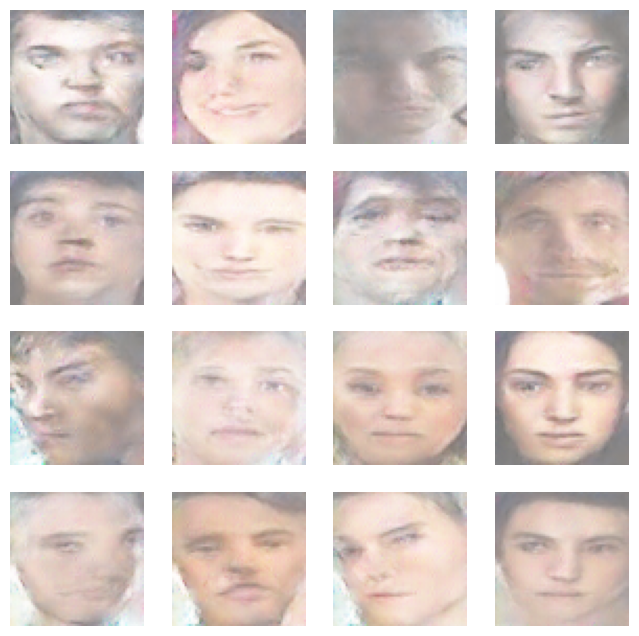

In [ ]:
noise = tf.random.normal([16, 128])  # Generate random noise vectors

# generated_images = gan.generator(noise)
generator_model = tf.keras.models.load_model('best_model.h5')
generated_images = generator_model.predict(noise) # Generate images using the generator model

fig = plt.figure(figsize=(8, 8))  # Create a figure to hold the subplots

for i in range(generated_images.shape[0]):  # Iterate over the generated images
  plt.subplot(4, 4, i + 1)  # Create a subplot in a 4x4 grid, with index i+1
  plt.imshow((generated_images[i,:,:,] * 0.5 + 0.5))  # Display the generated image
  plt.axis("off")  # Turn off the axes for the subplot

plt.show()  # Display the figure with the generated images

### ***5.10. Save the model***###

In [ ]:
generator.save('/content/generator_model_last.h5')
